## Prepare input structures

We first start by preparing the input ASE database. In the subfolder `golddac/test.xyz` there are a 312 total of MOF + gas configurations for 26 MOFs. The original `GoldDAC` dataset can be found at https://github.com/hspark1212/DAC-SIM/tree/main/assets/GoldDAC.

In [1]:
from dotenv import load_dotenv

load_dotenv()

from ase.io import read

atoms_list = read("golddac/test.xyz", index=":")

In [2]:
# Collect by MOF name
from collections import defaultdict

mof_dict = defaultdict(list)

for atoms in atoms_list:
    mof_name = atoms.info["group"]
    mof_dict[mof_name].append(atoms)
print(len(mof_dict))

26


## Demo Interaction (Adsorption) energy between MOF and gas molecules (CO2, H2O)

In [3]:
from mlip_arena.models import MLIPEnum
from mlip_arena.tasks.utils import get_calculator
from ase import units

for model in MLIPEnum:
    print(model)
    break
calc = get_calculator(
    calculator_name=model,
    calculator_kwargs=None,
    dispersion=True,
    dispersion_kwargs=dict(damping='bj', xc='pbe', cutoff=40.0 * units.Bohr),
)

No module named 'deepmd'


2025-01-10 16:24:46.439 | INFO     | mlip_arena.tasks.utils:get_calculator:30 - Using device: cuda:0


MLIPEnum.MACE-MP(M)
Selected GPU cuda:0 with 40339.31 MB free memory from 1 GPUs
Selected GPU cuda:0 with 40339.31 MB free memory from 1 GPUs
Default dtype float32 does not match model dtype float64, converting models to float32.


2025-01-10 16:24:46.593 | INFO     | mlip_arena.tasks.utils:get_calculator:42 - Using calculator: <mlip_arena.models.externals.mace-mp.MACE_MP_Medium object at 0x7f8e9a0846d0>
2025-01-10 16:24:46.640 | INFO     | mlip_arena.tasks.utils:get_calculator:54 - Using dispersion: <torch_dftd.torch_dftd3_calculator.TorchDFTD3Calculator object at 0x7f8e99f75290>


In [4]:
import pandas as pd
from tqdm.auto import tqdm

results = []

for mof_name, atoms_list in tqdm(mof_dict.items()):

    for atoms in atoms_list:
        name_split = atoms.info["name"].split("_")
        gas_name = name_split[1]
        region = name_split[2]  # R: repulsion E: equilibrium P: weak-attraction
        adsorption_type = name_split[3]  # N, A
        if adsorption_type == "A":
            dist = name_split[4]
        elif adsorption_type == "N":
            if region == "R" or region == "E":
                dist = name_split[4].split("-")[1]
            elif region == "P":
                dist = name_split[4].split("-")[0]
            else:
                raise ValueError(f"Unknown region: {region}")
        else:
            raise ValueError(f"Unknown adsorption type: {adsorption_type}")

        # True energies (PBE+D3)
        true_te = atoms.info["DFT_E_total"]
        true_ie = atoms.info["DFT_E_int"]

        # Predicted energies
        tags = atoms.get_tags()
        framework_gas = atoms.copy()
        framework = framework_gas[tags == 0]
        gas = framework_gas[tags == 1]

        pred_te = calc.get_potential_energy(framework_gas)
        pred_ie = (
            pred_te
            - calc.get_potential_energy(framework)
            - calc.get_potential_energy(gas)
        )

        # Collect results
        row_data = {
            "mof_name": mof_name,
            "gas": gas_name,
            "region": region,
            "adsorption_type": adsorption_type,
            "dist": dist,
            "true_te": true_te,
            "true_ie": true_ie,
            "pred_te": pred_te,
            "pred_ie": pred_ie,
        }
        results.append(row_data)

# Convert to DataFrame
df = pd.DataFrame(results)

  0%|          | 0/26 [00:00<?, ?it/s]/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/torch_dftd/torch_dftd3_calculator.py:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cell: Optional[Tensor] = torch.tensor(
100%|██████████| 26/26 [01:55<00:00,  4.44s/it]


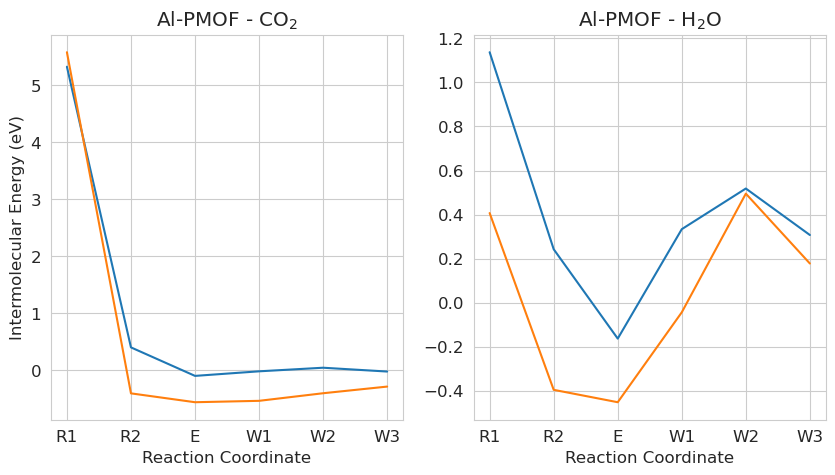

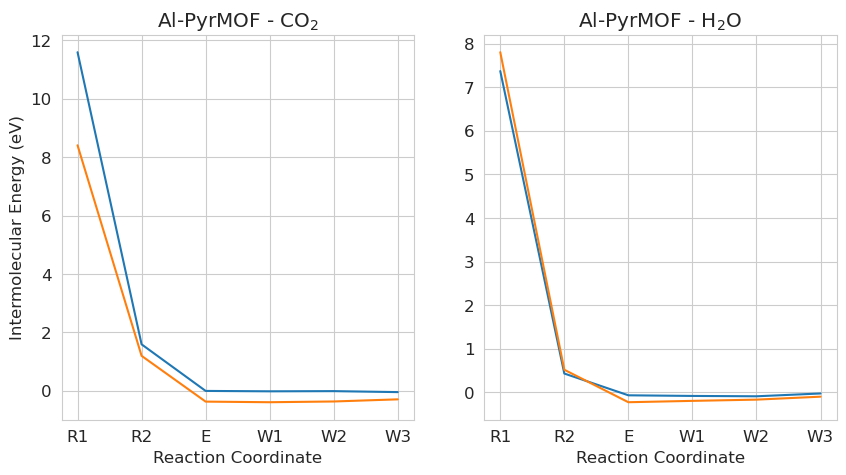

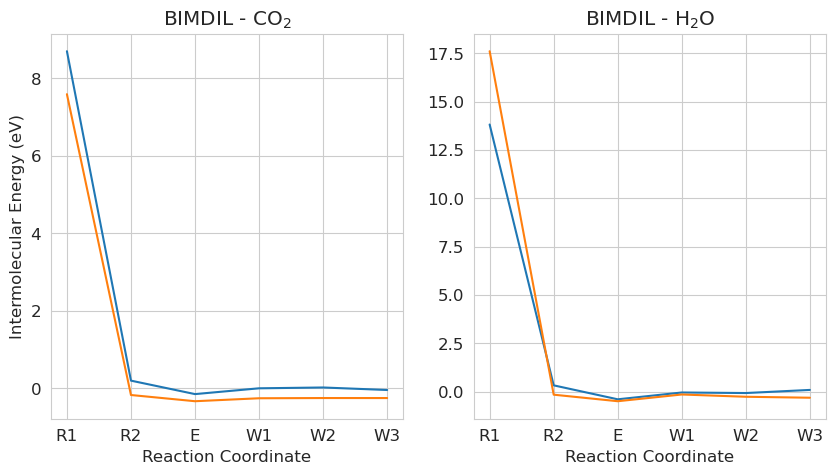

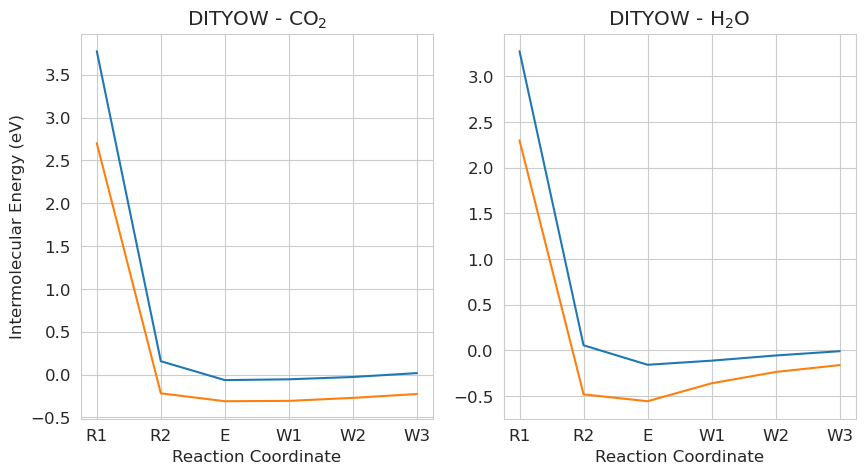

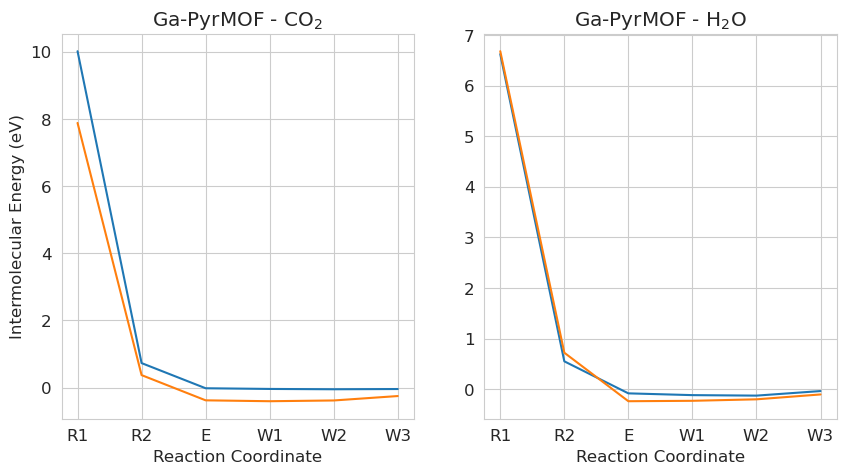

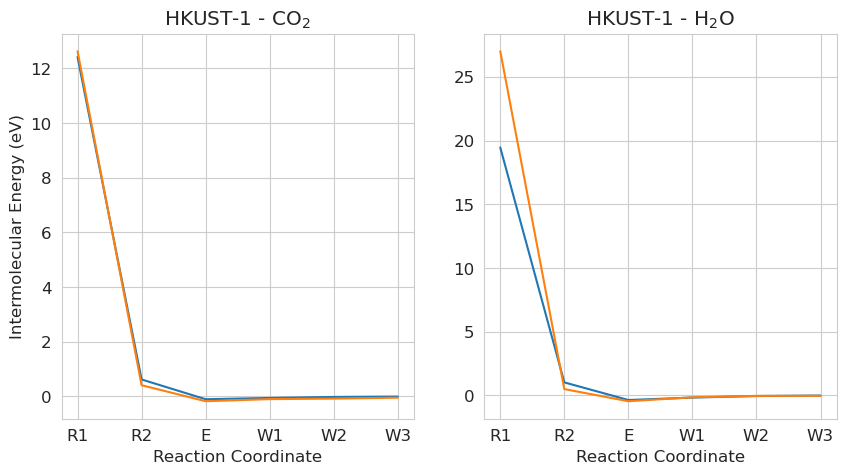

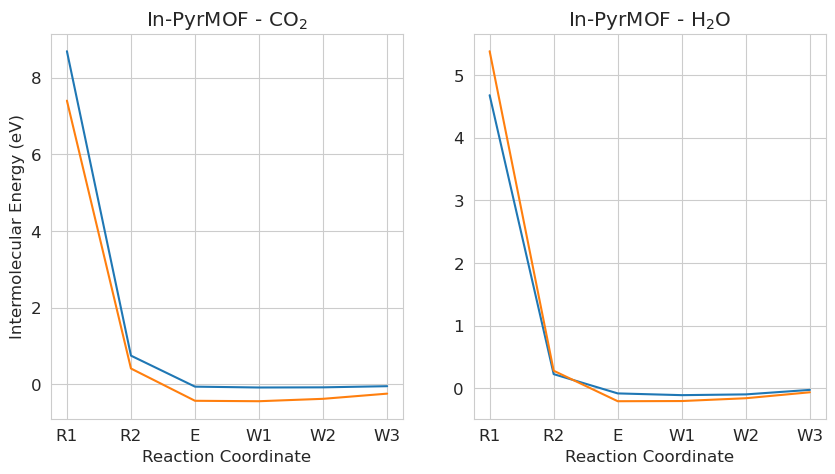

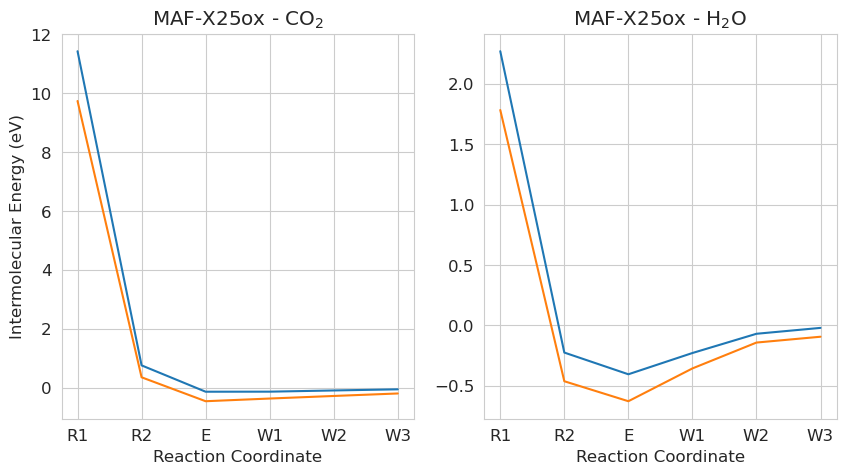

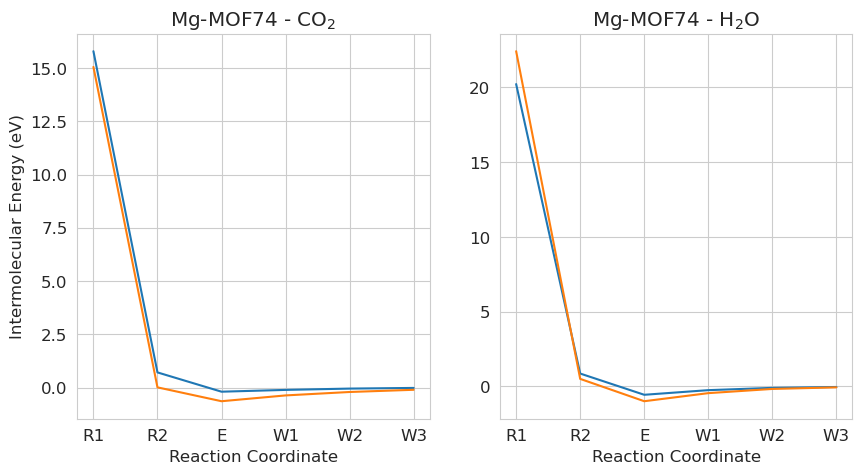

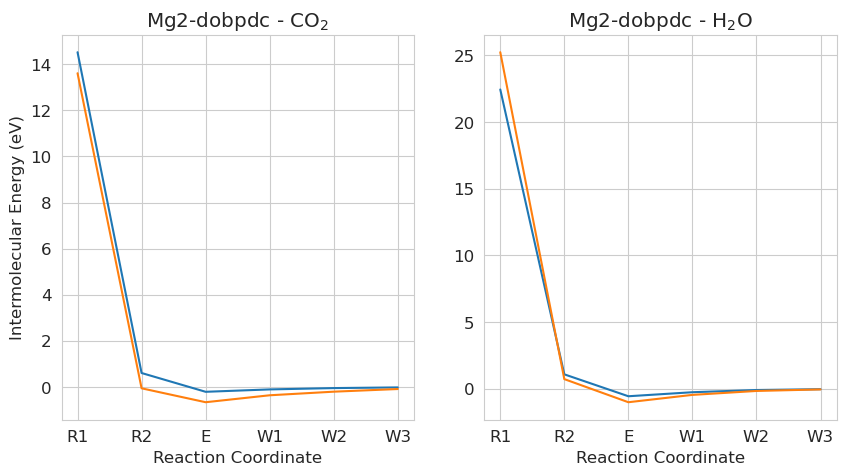

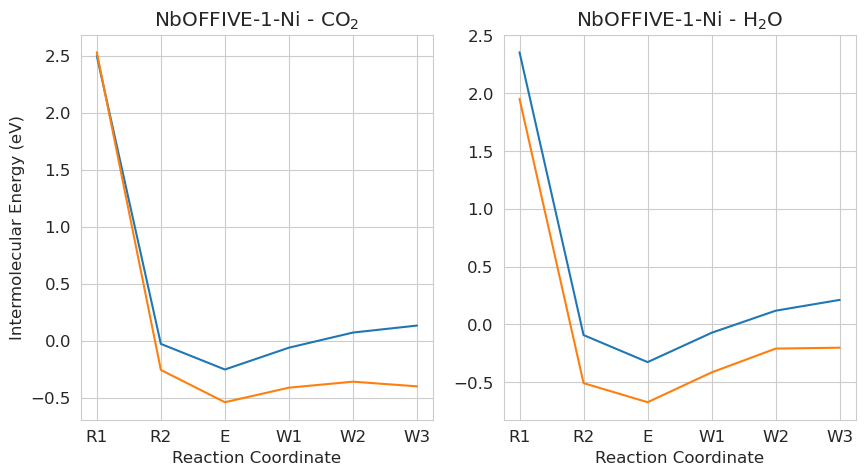

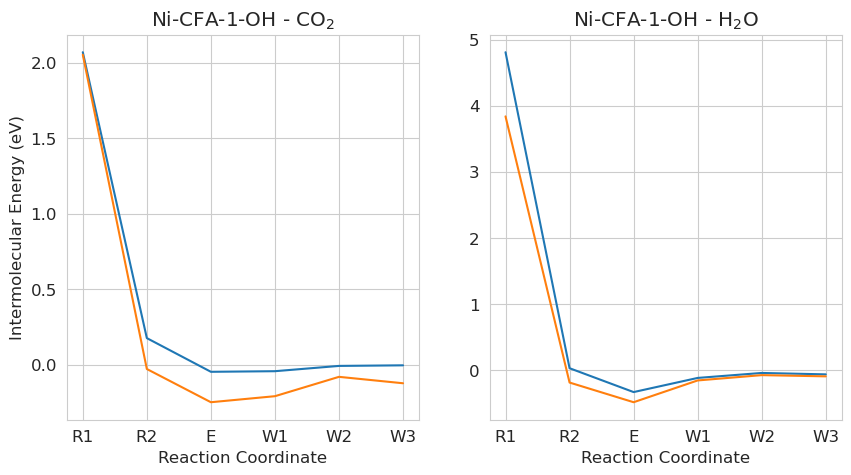

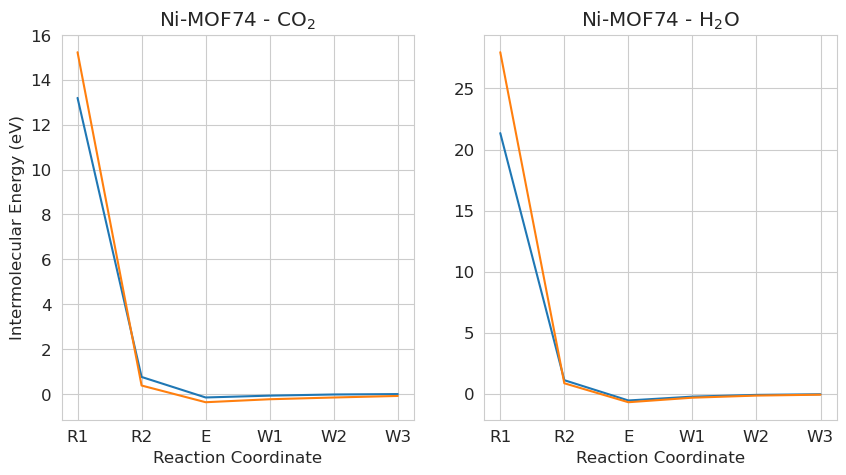

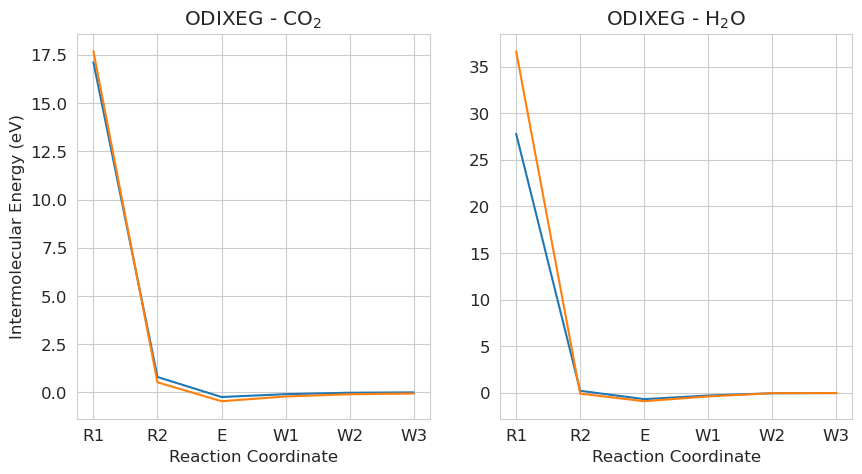

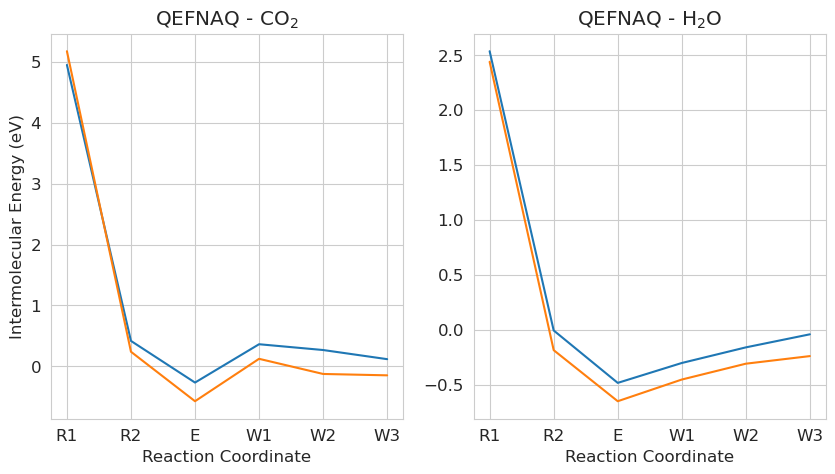

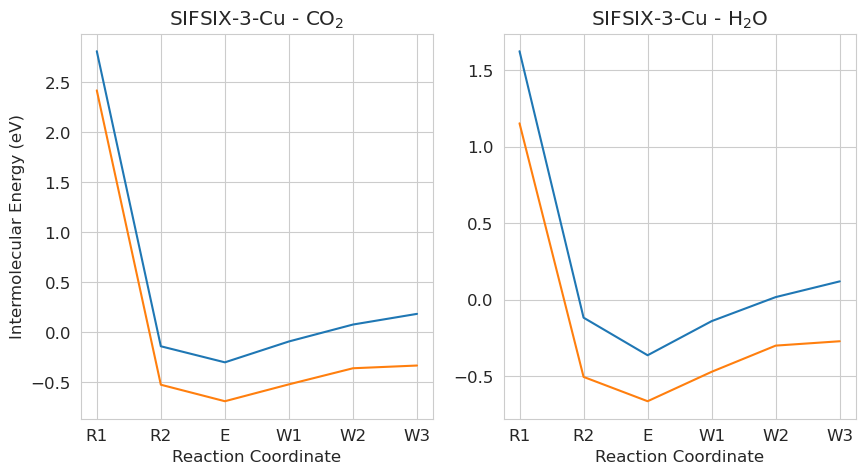

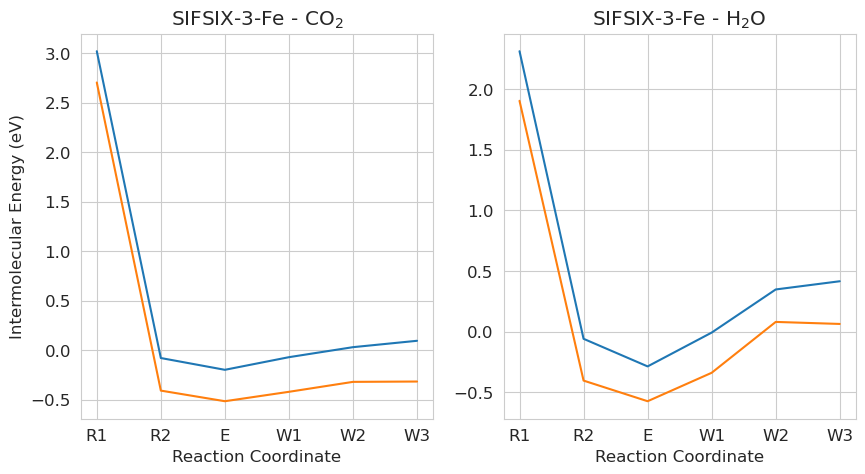

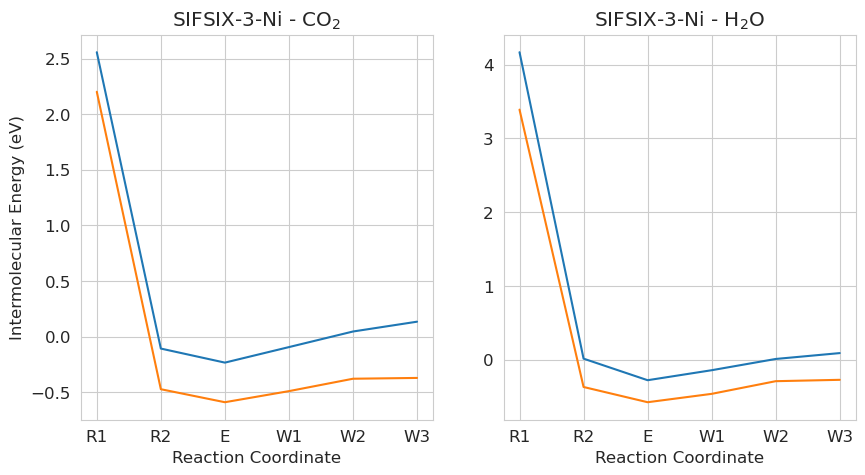

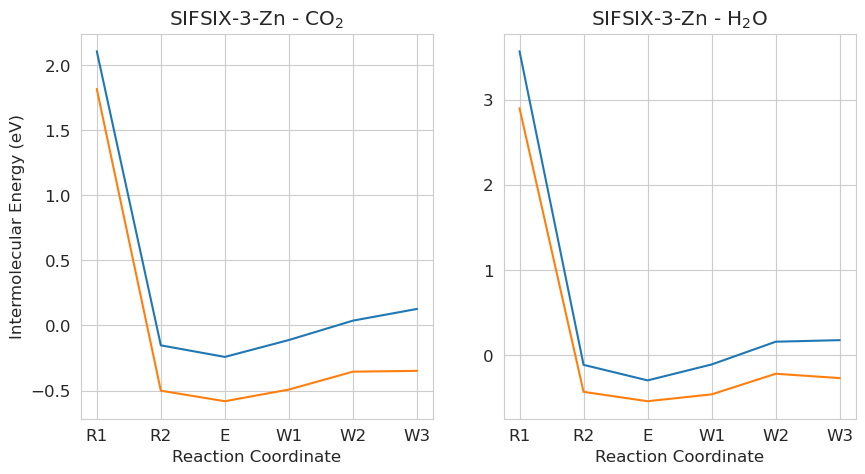

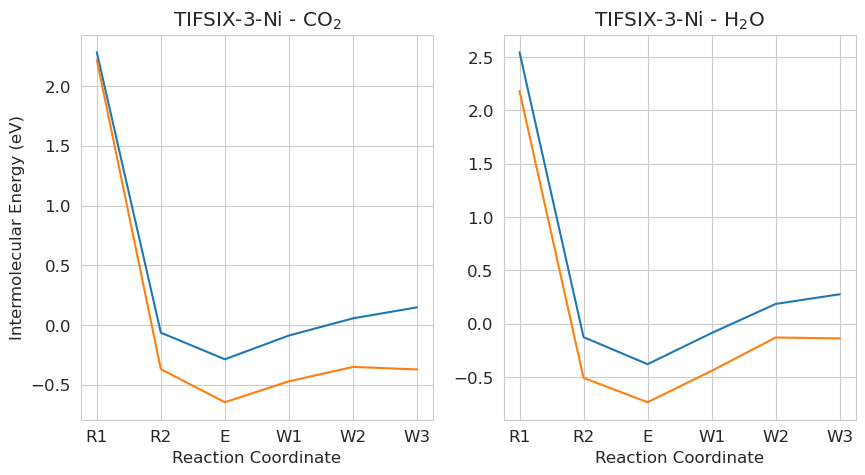

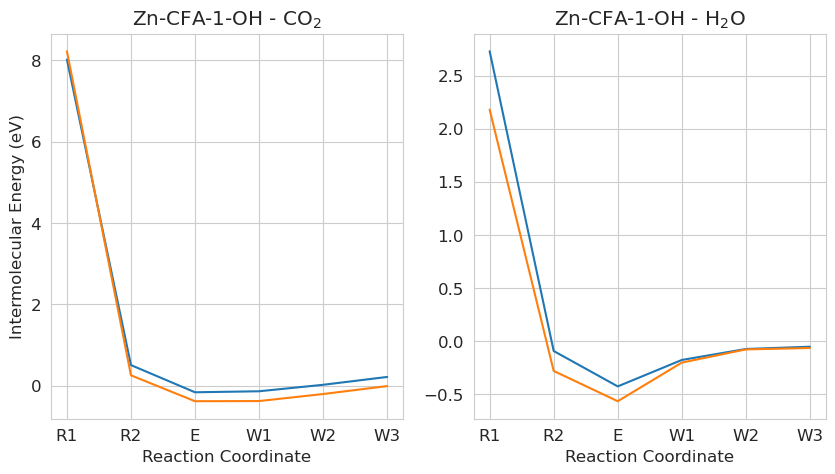

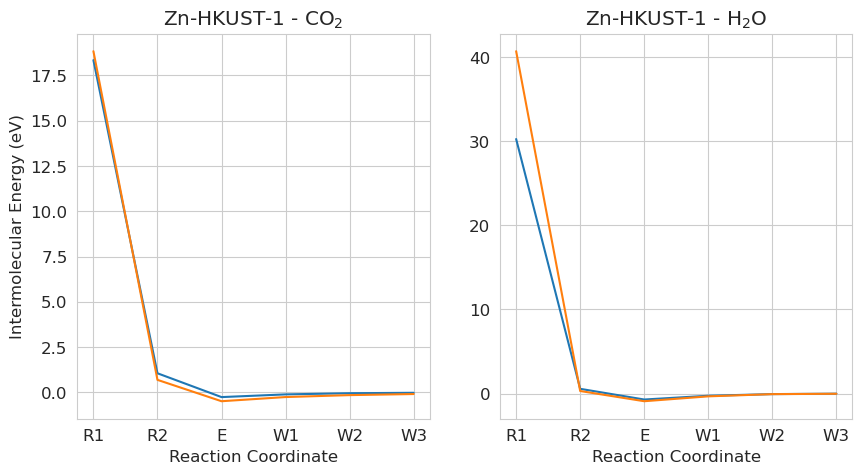

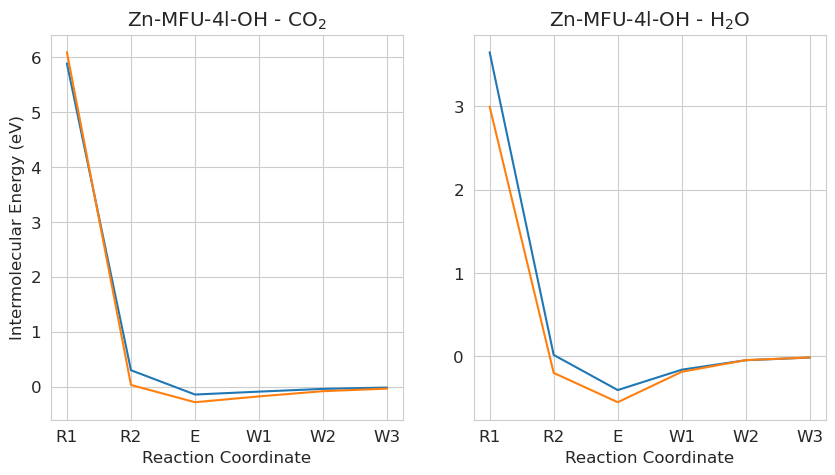

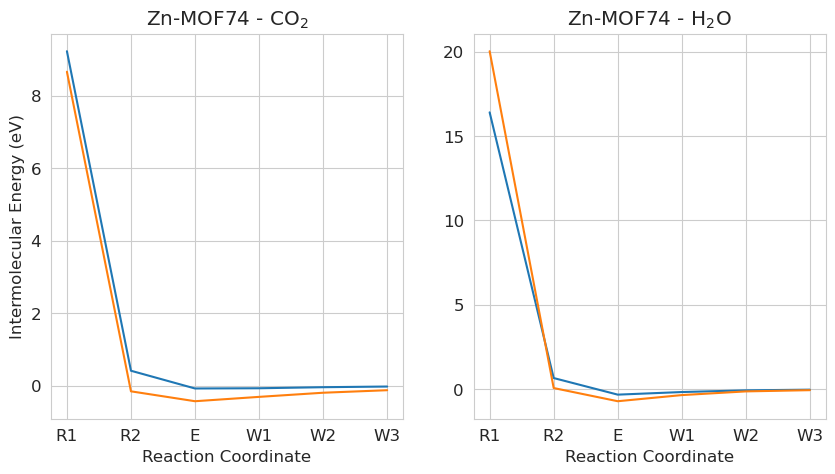

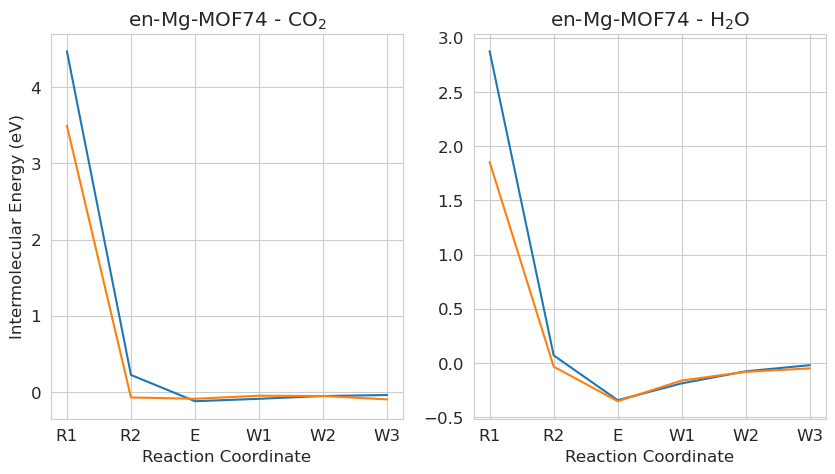

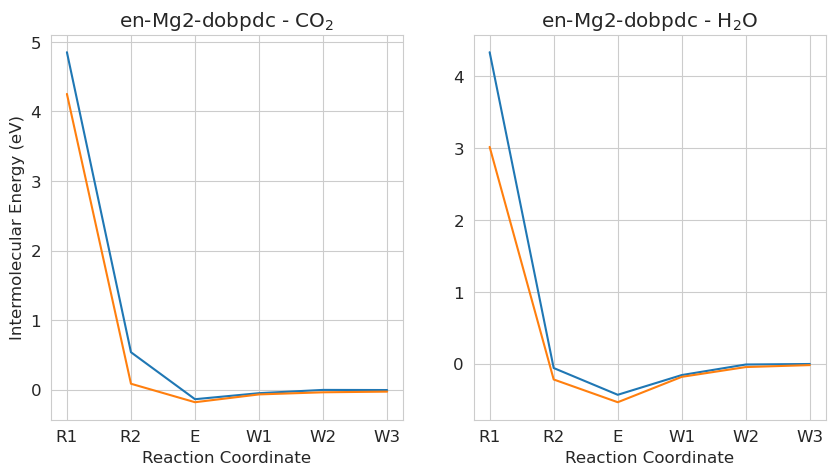

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
plt.rcParams["font.size"] = 12

for mof_name, mof_df in df.groupby("mof_name"):
    # Sort by region and distance
    df_co2 = mof_df[mof_df["gas"] == "CO2"].sort_values(["region", "dist"])
    df_h2o = mof_df[mof_df["gas"] == "H2O"].sort_values(["region", "dist"])
    region_order = {"R": 0, "E": 1, "P": 2}
    df_co2 = df_co2.sort_values(by=["region", "dist"], key=lambda x: x.map(region_order))
    df_h2o = df_h2o.sort_values(by=["region", "dist"], key=lambda x: x.map(region_order))

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
    # CO2
    ax = axes[0]
    sns.lineplot(data=df_co2, x=["R1", "R2", "E", "W1", "W2", "W3"], y="true_ie", ax=ax)
    sns.lineplot(data=df_co2, x=["R1", "R2", "E", "W1", "W2", "W3"], y="pred_ie", ax=ax)
    ax.set_title(f"{mof_name} - CO$_2$")
    ax.set_ylabel("Intermolecular Energy (eV)")
    ax.set_xlabel("Reaction Coordinate")
    # H2O
    ax = axes[1]
    sns.lineplot(data=df_h2o, x=["R1", "R2", "E", "W1", "W2", "W3"], y="true_ie", ax=ax)
    sns.lineplot(data=df_h2o, x=["R1", "R2", "E", "W1", "W2", "W3"], y="pred_ie", ax=ax)
    axes[1].set_title(f"{mof_name} - H$_2$O")
    axes[1].set_ylabel(None)
    axes[1].set_xlabel("Reaction Coordinate")
    plt.show()
